# Cats-vs.-Dogs Image Classification. CNNs: Sequential Models

Traditional machine learning models, as explored in the previous section, struggle to accurately classify images of cats and dogs due to the high feature-to-sample ratio (67,500 features for 2,000 samples), necessitating dimensionality reduction techniques like PCA or HOG. This notebook tackles the image classification challenge using convolutional neural networks (CNNs), which are well-suited for processing high-dimensional image data.

The preprocessed dataset comprises 2,000 images of cats ($y=0$) and dogs ($y=1$), each resized to 150x150 pixels with three color channels, resulting in 67,500 features per image. To accelerate training and optimize computational efficiency, it is recommended to use a GPU environment in Google Colab, which significantly reduces computation times for the resource-intensive CNN training process. This notebook demonstrates the potential of CNNs for cat/dog classification, achieving a 0.713 accuracy.

- **Dataset Reference**: Sachin, Shaunthesheep (2020). Dataset: Cats-vs-Dogs : image dataset for binary classification. URL: [https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset](https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset)

## Setup: Importing Packages and Defining Utility Functions
The following cells import the required packages and defines functions to enhance code readability and prevent duplication.

In [ ]:
# General imports
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import requests
import zipfile
import io
import seaborn as sns
from math import ceil

# Scikit-learn: machine learning library
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Tensorflow and Keras: neural network framework
from tensorflow.config.experimental import enable_op_determinism
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import set_random_seed
from keras.optimizers import RMSprop
from keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential

In [ ]:
# Global variables
BASE_URL = "https://raw.githubusercontent.com/alexARC26/portfolio-classification-neural-networks/main/data/"
DATASET_URL_1 = BASE_URL + "CatsDogsDataset_1.zip"
DATASET_URL_2 = BASE_URL + "CatsDogsDataset_2.zip"
CSV_FILENAME = "CatsDogsDataset.csv"
IMAGE_SIZE = 150
CLASS_NAMES = ["Cat", "Dog"]

# Data input functions
def read_csv_from_github_zip(zip_url, csv_filename):
    """
    Download a ZIP file from a GitHub URL, extract a specified CSV, and return it as a DataFrame.

    Parameters:
        zip_url (str): URL of the ZIP file hosted on GitHub.
        csv_filename (str): Name of the CSV file to extract from the ZIP.

    Returns:
        pd.DataFrame: DataFrame containing the CSV data, or None if an error occurs.
    """
    try:
        # Download the ZIP file from the provided URL. Raise an exception for HTTP errors (e.g., 404)
        response = requests.get(zip_url)
        response.raise_for_status()

        # Create a file-like object from the downloaded ZIP content
        zip_content = io.BytesIO(response.content)

        # Open the ZIP file for reading
        with zipfile.ZipFile(zip_content, 'r') as zf:
            # Check if the specified CSV exists in the ZIP
            if csv_filename not in zf.namelist():
                raise ValueError(f"CSV file '{csv_filename}' not found in ZIP")

            # Extract and read the CSV file directly into a DataFrame
            with zf.open(csv_filename) as csv_file:
                df = pd.read_csv(csv_file)

        # Return the resulting DataFrame
        return df

    except requests.exceptions.RequestException as e:
        # Handle network or HTTP errors during download
        print(f"Error downloading ZIP from {zip_url}: {e}")
        return None

    except zipfile.BadZipFile:
        # Handle cases where the downloaded file is not a valid ZIP
        print(f"Error: The file at {zip_url} is not a valid ZIP")
        return None

    except Exception as e:
        # Catch any other errors (e.g., CSV parsing issues, file corruption)
        print(f"Error processing ZIP or CSV: {e}")
        return None

# Plot image functions
def plot_single_image(X_values, subtitle_text="", colorMap=None, yText=None):
    """
    Plot a single image with optional subtitle and text label.

    Parameters:
    - X_values: Array-like, image data (1D or 3D format).
    - subtitle_text: String, title for the image (default: "").
    - colorMap: String, matplotlib colormap for the image (default: None).
    - yText: String, text to display on the y-axis (default: None).
    """
    # Check if X_values is in 1D format and reshape to 3D if necessary
    dim_X = len(X_values.shape)
    if dim_X == 1:
        n_color_channels = int(X_values.shape[0] / (IMAGE_SIZE * IMAGE_SIZE))

        # Reshape 1D array to 3D (height, width, channels) and normalize pixel values
        X_values = np.array(X_values).reshape(IMAGE_SIZE, IMAGE_SIZE, n_color_channels)
        X_values = X_values / 255

        # Set colormap to grayscale for single-channel images
        colorMap = "gray"

    # Display the image, add subtitle and hide axes for tidier visualization
    plt.imshow(X_values, interpolation='nearest', cmap=colorMap)
    plt.title(subtitle_text, fontsize=14, loc="left")
    plt.axis('off')

    # Add optional text label on the y-axis
    if yText is not None:
        plt.text(x=-0.2, y=0.5, s=yText, ha='center', va='center',
                 transform=plt.gca().transAxes, fontsize=14)

def plot_gallery(X_values, y_values, y_labels=None, selection=None, main_title="Image Gallery", title_offset=[0.075, 0.97]):
    """
    Plot a gallery of images with their class labels and optional predicted labels.

    Parameters:
    - X_values: Array-like or DataFrame, image data.
    - y_values: Array-like, true class labels for the images.
    - y_labels: Array-like, predicted class labels (default: None).
    - selection: List, indices of images to display (default: None, uses all images).
    - main_title: String, title for the gallery (default: "Image Gallery").
    - title_offset: List, [x, y] coordinates for the main title (default: [0.075, 0.97]).
    """
    # Use all images if no selection is provided
    if selection is None:
        selection = list(range(len(y_values)))

    # Initialize figure with specified size. Also, set # of images to display in n_rows
    fig = plt.figure(figsize=(17, 10))
    n_in_gallery = 15
    n_rows = 3

    # Select a random subset of images from the selection
    n_in_selection = len(selection)
    random_subset = random.sample(sorted(selection), min(n_in_gallery, n_in_selection))

    # Plot each image in the gallery
    for i in range(min(n_in_gallery, n_in_selection)):
        plt.subplot(n_rows, int(np.ceil(n_in_gallery / n_rows)), i + 1)
        random_index = random_subset[i]

        # Extract single image data (handle DataFrame or array input)
        if isinstance(X_values, pd.DataFrame):
            single_row = X_values.iloc[random_index, ]
        else:
            single_row = X_values[random_index, ]

        # Create subtitle with true class name and optional predicted label
        subtitle_text = CLASS_NAMES[y_values[random_index]]
        if y_labels is not None:
            subtitle_text += ". Pred: " + CLASS_NAMES[y_labels[random_index]]

        plot_single_image(X_values=single_row, subtitle_text=subtitle_text)

    # Adjust layout and add main title
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(main_title, x=title_offset[0], y=title_offset[1], fontsize=16)
    plt.show()

# Data Load
The following cell loads the dataset as a DataFrame, pre-processesed as done within from the `Data_Transformation` notebook in the `utils` folder (specifically, it uses the first 2,000 images (forming the dataset rows), resized to 150x150 pixels). Moreover, it divides the variables into the pixels' RGB values (`complete_X`) and reponse variable (`complete_y`).

In [ ]:
print("Reading datafiles the ZIP files from Github...")
cats_dogs_df_part_1 = read_csv_from_github_zip(DATASET_URL_1, CSV_FILENAME)
cats_dogs_df_part_2 = read_csv_from_github_zip(DATASET_URL_2, CSV_FILENAME)

if cats_dogs_df_part_1 is not None and cats_dogs_df_part_2 is not None:
  # Both datasets are concatenated
  cats_dogs_df = pd.concat([cats_dogs_df_part_1, cats_dogs_df_part_2]).reset_index(drop=True)

  # Data split into features and dependent variable
  complete_X = cats_dogs_df.iloc[:,:-1]
  complete_y = cats_dogs_df["Class"].astype(int)
  print("Data loaded successfully.")
else:
  print("Failed to load data from GitHub.")

Reading datafiles the ZIP files from Github...
Data loaded successfully.


Data can either be visualized as a matrix of RGB values or as images. Moreover, `complete_X` is given a four-dimensional shape (number of images, width, height, color channels) and unused variables are deleted with `del` to save memory efficiently.

In [ ]:
cats_dogs_df.head()

,R_1_1,G_1_1,B_1_1,R_1_2,G_1_2,B_1_2,R_1_3,G_1_3,B_1_3,R_1_4,...,R_150_148,G_150_148,B_150_148,R_150_149,G_150_149,B_150_149,R_150_150,G_150_150,B_150_150,Class
0,203,164,87,208,169,92,210,171,94,212,...,1,1,0,1,1,0,1,1,0,0
1,37,42,38,38,42,41,38,42,45,37,...,46,32,23,61,48,39,39,26,17,0
2,28,33,39,12,16,25,22,26,38,38,...,195,194,5,184,181,8,172,167,5,0
3,223,224,219,223,224,219,223,224,219,222,...,212,211,209,215,212,207,216,212,209,0
4,134,110,66,135,111,67,139,117,70,145,...,104,92,66,91,81,56,90,80,55,0


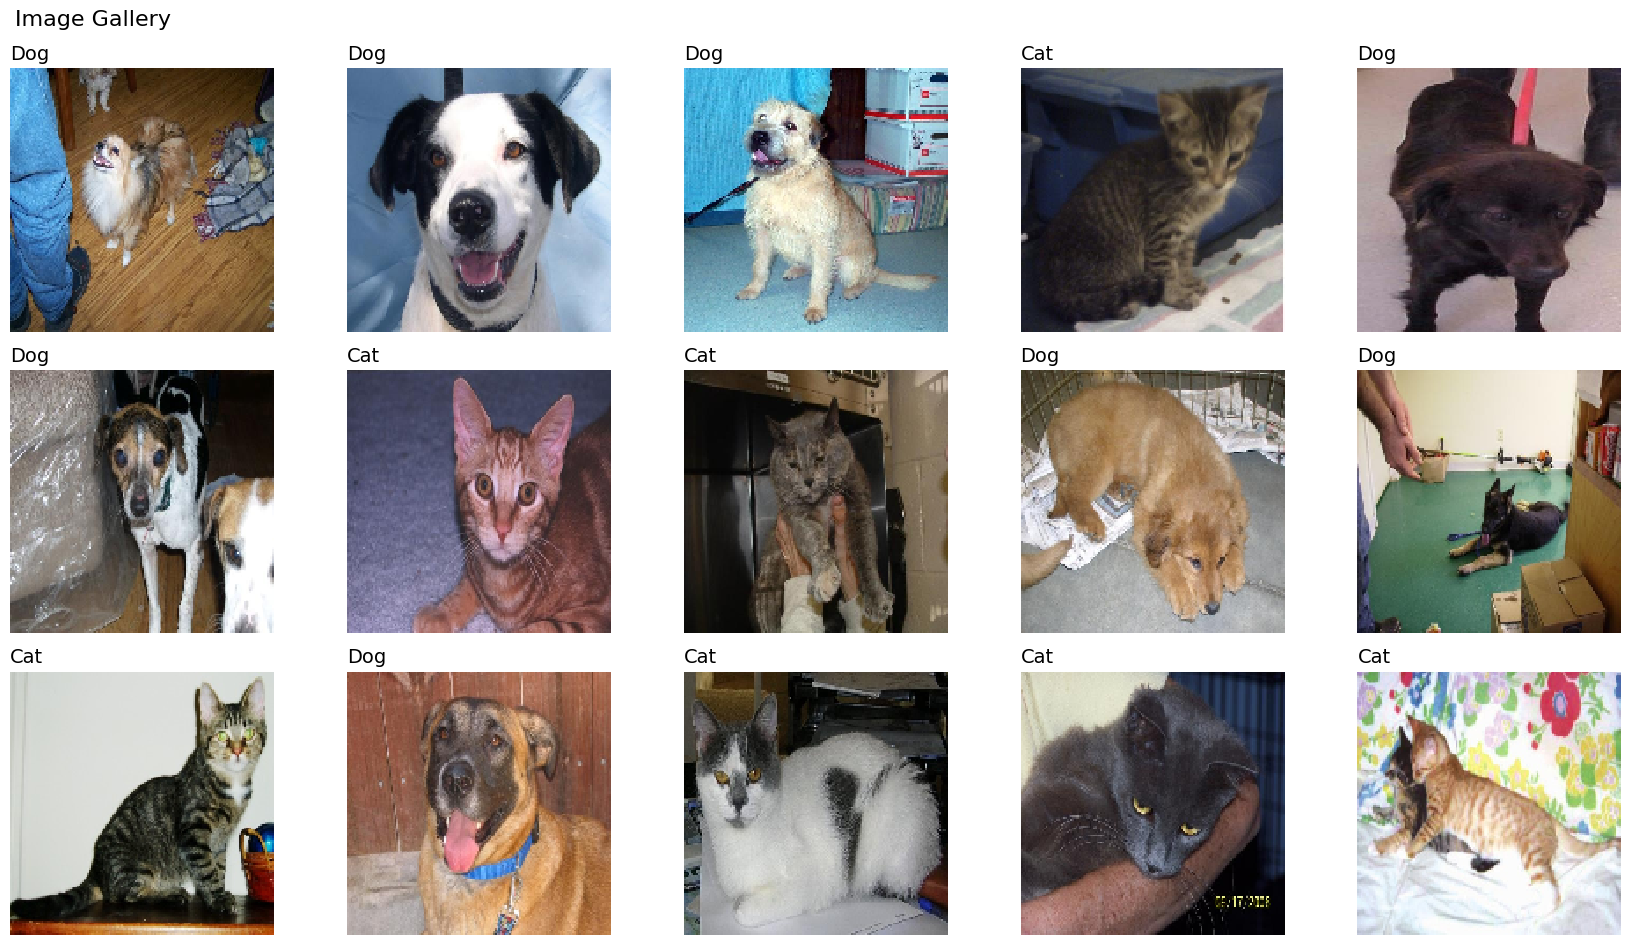

In [ ]:
# Plot gallery of images
plot_gallery(complete_X, complete_y)

# Features to 3D format and normalization
complete_X = (np.array(complete_X).reshape(2000,IMAGE_SIZE,IMAGE_SIZE,3))/255

# Remove no more used variables to lighten resources usage
del(cats_dogs_df_part_1)
del(cats_dogs_df_part_2)
del(cats_dogs_df)

# Data Preparation
With 2,000 images (rows) and 67,500 features, we will divide the dataset into three: the train set (70 %), validation set (15 %) and test set (15 %). The former two are used to train the model and calibrate the parameters of the model, whereas the late is an independent dataset used to measure the performance of the model in unseen data.

In [ ]:
total_n = complete_X.shape[0]
test_n = int(0.15*total_n); train_n = int(0.7*total_n); val_n = total_n-train_n-test_n

# Randomly decide the datasets for training, validation and testing
X_train_val, test_X, y_train_val, test_y = train_test_split(complete_X, complete_y, test_size=test_n, random_state=1)
train_X, val_X, train_y, val_y = train_test_split(X_train_val, y_train_val, test_size=val_n, random_state=1)

print("DATASET : Train: "+str(train_n)+", Validation: "+str(val_n)+", Test: "+str(test_n))

DATASET : Train: 1400, Validation: 300, Test: 300


# Convolutional Neural Network (CNN) models
This section contains the training and testing of **two different CNN models** in the task of distinguishing dog and cat images. The models follow typical CNN architectures, composed of two different blocks of layers which can be added by using the customizable functions `add_convolutional_blocks` and `add_output_block`:

* **Convolutional blocks**, which extract hierarchical features from input images (e.g., edges, textures in early layers; objects, patterns in deeper layers). In particular, they consist of two 2D convolutional layers (`Conv2D`), followed by a pooling layer. Features are normalized after the convolutional layer (`MaxPooling2D`). Further details are given below:
  * `Conv2D`: layer which applies a 2D convolution with `conv_filters` filters (e.g. 32 filters) using a kernel of size `conv_kernel_size` (e.g., 3x3) to extract features like edges or textures. Non-lineality is introduced with the `activation` function (in most cases, 'relu') and the  `padding='same'` adds zeros around the input to maintain the spatial dimensions (height and width) of the output.
  *`MaxPooling2D`: layer which reduces the spatial dimensions (height and width) of the feature maps by taking the maximum value in each `pool_size` window (e.g., `(2,2)`).

* **Output blocks**, which transform spatial feature maps into a output to solve classification problems. In particular, the flattened multi-dimensional features pass a dense layer with normalization and dropout, which mitigates overfitting, and reach the final sigmoid layer, which produces the classification output. Further details are given below:  
  * `Flatten`: layer which converts the multi-dimensional feature maps into a 1D vector.
  * `Dense` with ReLU activation : layer in which `dense_units` neurons are fully inter-connected to learn high-level patterns or relationships. The ReLu function introduces non-linearity.
  * `Dropout`: layer which mitigates the excessive reliance on specific neurons (overfitting) by randomly disabling a `dropout_value` fraction of the neurons.
  * `Dense` with sigmoid activation : a single neuron outputs the probability of the image of belonging to a dog.

The potential of these models to solve the problem at hand is proved by a first, simpler CNN model (CNN-C1), with a single convolutional block, whereas the second model (CNN-C3) combines three of these blocks to capture higher level features like object shapes. In the training process, a batch size of 64 was used to balance computational efficiency and gradient stability and early stopping if the results in the validation set did not improve in 15 epochs. As part of **hyperparameter tuning**, three different learning rates (0.001, 0.0001, and 0.01) have been explored for the models' optimization. The best model will be evaluated using the independent test dataset. In particular, **two measures** will be used for the comparisons:

* Accuracy: the proportion of correct predictions made by a model out of all predictions. Its value ranges from 0 to 1, which would mean that the model perfectly predicts the data.
* F1 score: the harmonic mean of precision (proportion of positive predictions that are correct) and recall (proportion of actual positives correctly identified). In case where the classes are balanced, such as ours, it assures a balance between false positives and false negatives. Its value ranges from 0 to 1, which would mean that the model perfectly predicts the data.

In [ ]:
def add_convolutional_blocks(cnn_model, conv_filters=32, conv_kernel_size=(3,3),
                             conv_activation='relu', conv_padding='same', pool_size=(2,2)):
    """
    Adds convolutional blocks to a CNN model, each consisting of two Conv2D layers,
    batch normalization, and a max pooling layer.

    Parameters:
        cnn_model: Keras Sequential model to add layers to.
        conv_filters: Integer or list of integers specifying the number of filters for each Conv2D layer.
        conv_kernel_size: Tuple specifying the kernel size for Conv2D layers (default: (3,3)).
        conv_activation: Activation function for Conv2D layers (default: 'relu').
        conv_padding: Padding type for Conv2D layers (default: 'same').
        pool_size: Tuple specifying the pool size for MaxPooling2D layers (default: (2,2)).

    Returns:
        keras.Sequential: The updated Keras model with added convolutional blocks.
    """
    # Convert conv_filters to a list if it is a single integer
    conv_filters = [conv_filters] if not(isinstance(conv_filters, list)) else conv_filters
    n_conv_blocks = len(conv_filters)

    # Iterate through the number of convolutional blocks
    for i in range(n_conv_blocks):
        cnn_model.add(Conv2D(conv_filters[i], conv_kernel_size,
                             activation=conv_activation, padding=conv_padding))
        cnn_model.add(BatchNormalization())
        cnn_model.add(Conv2D(conv_filters[i], conv_kernel_size,
                             activation=conv_activation, padding=conv_padding))
        cnn_model.add(BatchNormalization())

        # Add max pooling to reduce spatial dimensions
        cnn_model.add(MaxPooling2D(pool_size))

    return(cnn_model)

def add_output_block(cnn_model, dense_units=256, dense_activation='relu', dropout_value=0.5):
    """
    Adds the output block to a CNN model, consisting of a flatten layer, a dense layer,
    batch normalization, dropout, and a final dense layer for binary classification.

    Parameters:
        cnn_model: Keras Sequential model to add layers to.
        dense_units: Number of units in the dense layer (default: 256).
        dense_activation: Activation function for the dense layer (default: 'relu').
        dropout_value: Dropout rate for regularization (default: 0.5).

    Returns:
        keras.Sequential: The updated Keras model with added output block.
    """
    # Flatten the output of the previous layer to a 1D vector
    cnn_model.add(Flatten())
    cnn_model.add(Dense(dense_units, activation=dense_activation))
    cnn_model.add(BatchNormalization())

    # Add dropout to prevent overfitting and a sigmoid final dense layer binary classification
    cnn_model.add(Dropout(dropout_value))
    cnn_model.add(Dense(1, activation='sigmoid'))

    return(cnn_model)

def train_cnn_model(train_data, val_data, cnn_model, learning_rate=0.001,
                    epochs=30, batch_size=64, patience_epochs=15):
    """
    Trains a CNN model on provided training and validation data, with checkpointing to save
    the best model weights based on validation accuracy. If the validation accuracy
    is not improved in patience_epochs, the fitting process is stoped.

    Parameters:
        train_data: Tuple of (train_X, train_y) containing training images and labels.
        val_data: Tuple of (val_X, val_y) containing validation images and labels.
        cnn_model: Keras Sequential model to train.
        learning_rate: Learning rate for the RMSprop optimizer (default: 0.001).
        epochs: Number of training epochs (default: 30).
        batch_size: Number of training samples processed together in one pass (default: 64).
        patience_epochs: epochs to stop the fit if the accuracy has not improved (default: 15).

    Returns:
        Tuple of (trained cnn_model, training history).
    """
    # Unpack training and validation data
    train_X, train_y = train_data
    val_X, val_y = val_data

    # Calculate steps_per_epoch and validation_steps
    train_samples = len(train_X)
    val_samples = len(val_X)
    steps_per_epoch = ceil(train_samples / batch_size)
    validation_steps = ceil(val_samples / batch_size)

    # Define checkpoint path to save weights with best validation accuracy
    checkpoint_path = f"./ModelCheckpoints/model_lr_{learning_rate}.weights.keras"
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                               monitor='val_accuracy', mode='max', save_best_only=True)

    # Automatically halt training if the val_accuracy does not improve in 5 epochs
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience_epochs, restore_best_weights=True)

    # Compile the model with RMSprop optimizer and binary crossentropy loss. Train it
    cnn_model.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    nn_history = cnn_model.fit(x=train_X, y=train_y, validation_data=(val_X, val_y), epochs=epochs,
                               verbose=0, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,
                               callbacks=[model_checkpoint_callback, early_stopping],
                               # Needed for reproducibility
                               batch_size = batch_size, shuffle=False)

    # Load the best weights from checkpoint
    cnn_model.load_weights(checkpoint_path)
    return cnn_model, nn_history

def plot_nn_epochs(nn_history):
    """
    Visualizes training and validation accuracy and loss over epochs for a neural network.

    Parameters:
        nn_history: Keras' history object containing accuracy and loss metrics.

    Returns:
        None: Displays a matplotlib plot with two subplots for accuracy and loss.
    """

    # Extract accuracy and loss metrics from the history object
    acc = nn_history.history['accuracy']
    val_acc = nn_history.history['val_accuracy']
    loss = nn_history.history['loss']
    val_loss = nn_history.history['val_loss']

    # Create a DataFrame to organize data for plotting
    plot_df = pd.DataFrame({
        "Epoch": list(range(1, len(acc) + 1)) * 4,
        "Value": acc + val_acc + loss + val_loss,
        "Label": ["Accuracy (Training)"] * len(acc) + ["Accuracy (Validation)"] * len(acc) +
                 ["Loss (Training)"] * len(acc) + ["Loss (Validation)"] * len(acc)
    })

    sns.set_theme()
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot accuracy metrics (training and validation) on the first subplot
    sns.lineplot(data=plot_df[plot_df['Label'].isin(['Accuracy (Training)', 'Accuracy (Validation)'])],
                 x="Epoch", y="Value", hue="Label", style="Label", ax=ax1,
                 palette=["blue", "blue"], dashes=[[], (2, 2)], legend="brief")

    # Plot loss metrics (training and validation) on the second subplot
    sns.lineplot(data=plot_df[plot_df['Label'].isin(['Loss (Training)', 'Loss (Validation)'])],
                 x="Epoch", y="Value", hue="Label", style="Label", ax=ax2,
                 palette=["orange", "orange"], dashes=[[], (2, 2)], legend="brief")

    # Find the epoch with maximum training and validation accuracy
    max_train_acc_idx = np.argmax(acc)
    max_val_acc_idx = np.argmax(val_acc)
    max_train_acc = acc[max_train_acc_idx]
    max_val_acc = val_acc[max_val_acc_idx]

    # Annotate maximum training accuracy
    ax1.annotate(f'Max Train: {max_train_acc:.3f}',
                 xy=(max_train_acc_idx + 1, max_train_acc),
                 xytext=(max_train_acc_idx + 1, max_train_acc + 0.05),
                 arrowprops=dict(facecolor='blue', shrink=0.05, alpha=0.5),
                 fontsize=10, color='blue', ha='center')

    # Annotate maximum validation accuracy
    ax1.annotate(f'Max Val: {max_val_acc:.3f}',
                 xy=(max_val_acc_idx + 1, max_val_acc),
                 xytext=(max_val_acc_idx + 1, max_val_acc - 0.10),
                 arrowprops=dict(facecolor='blue', shrink=0.05, alpha=0.5),
                 fontsize=10, color='blue', ha='center')

    # Customize legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    ax1.legend(handles1, [label.replace("Accuracy", "").replace("(", "").replace(")", "").strip() for label in labels1],
               title="Accuracy", loc="upper left")
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(handles2, [label.replace("Loss", "").replace("(", "").replace(")", "").strip() for label in labels2],
               title="Loss", loc="upper left")

    # Set title for the subplots, the y-axis limits
    ax1.set_title("Accuracy over Epochs", loc="left")
    ax2.set_title("Loss over Epochs", loc="left")
    ax1.set_ylim(0, 1.02)
    ax2.set_ylim(0, max(plot_df[plot_df['Label'].isin(['Loss (Training)', 'Loss (Validation)'])]['Value']) * 1.1)
    plt.tight_layout()

    plt.show()

def select_best_cnn_model(models, val_data):
    """
    Selects the best CNN model based on validation accuracy computed using predict.

    Parameters:
        models: List of trained Keras Sequential models.
        val_data: Tuple of (val_X, val_y) containing validation images and labels.
                  - val_X: numpy array of validation images.
                  - val_y: numpy array of validation labels (binary).

    Returns:
        best_model: the selected Keras model.
    """
    val_X, val_y = val_data
    best_val_accuracy = -1.0
    best_model = None
    selected_index = -1

    for index, model in enumerate(models):
        # Get predictions on validation data
        val_predictions = model.predict(val_X, verbose=0)
        # Convert predictions to binary classes (threshold at 0.5)
        val_predictions_binary = (val_predictions > 0.5).astype(int).flatten()
        # Compute accuracy
        val_accuracy = accuracy_score(val_y, val_predictions_binary)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model
            selected_index = index

    print("The best model is the one in the index position: "+ str(selected_index))

    return best_model

def get_cnn_results(cnn_model, data_X, true_class, class_threshold = 0.5):
    """
    Evaluates a CNN model on test data, computing accuracy, F1 score, and plotting a confusion matrix.

    Parameters:
        cnn_model: Trained Keras Sequential model.
        data_X: Test data input (images).
        true_class: True labels for the test data.

    Returns:
        pd.DataFrame: DataFrame containing accuracy and F1 score.
    """
    # Predict class probabilities and convert to binary labels
    pred_class = cnn_model.predict(data_X).flatten()
    pred_class = (pred_class > class_threshold).astype(int)

    # Plot confusion matrix and return DataFrame with accuracy and F1 score
    plot_confusion_matrix(true_class, pred_class)

    return pd.DataFrame({"Accuracy": [accuracy_score(true_class, pred_class)],
                         "F1 Score": [f1_score(true_class, pred_class)]})

def load_previous_results():
    """
    Loads a DataFrame containing previous model performance results for comparison.

    Returns:
        pd.DataFrame: DataFrame with columns 'Model', 'Features', 'Metric', and 'Value'.
    """
    data = {
        "Model": ["Logistic Regression", "Logistic Regression", "Logistic Regression", "Logistic Regression",
                  "Decision Tree", "Decision Tree", "Decision Tree", "Decision Tree",
                  "Random Forest", "Random Forest", "Random Forest", "Random Forest"],
        "Features": ["PCA", "HOG", "PCA", "HOG",
                     "PCA", "HOG", "PCA", "HOG",
                     "PCA", "HOG", "PCA", "HOG"],
        "Metric": ["Accuracy", "Accuracy", "F1 Score", "F1 Score",
                   "Accuracy", "Accuracy", "F1 Score", "F1 Score",
                   "Accuracy", "Accuracy", "F1 Score", "F1 Score"],
        "Value": [0.470000, 0.646667, 0.450000, 0.670807,
                  0.500000, 0.613333, 0.503000, 0.639752,
                  0.566667, 0.700000, 0.585987, 0.700000]
    }
    return pd.DataFrame(data)

def plot_confusion_matrix(true_class, pred_class):
    """
    Plot two confusion matrices (absolute and normalized) side by side for binary classification.

    Parameters:
        true_class: Array of true class labels (e.g., test_y for cats vs. dogs).
        pred_class: Array of predicted class labels (e.g., test_pred_best from a model).

    Returns:
        None: Displays the plot with confusion matrices and accuracy.
    """
    # Set seaborn context for consistent font scaling (1.25x default)
    sns.set_context("notebook", font_scale=1.25)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Apply tight layout to adjust subplot spacing
    fig.tight_layout()

    # Define normalization options and titles (1. Absolute counts, 2. Row-normalized)
    normalize_options = [None, 'true']
    title_options = ['Absolute values', 'Normalized']
    titles_positions = [0.17, 0.15]

    # Iterate over the two subplots to create absolute and normalized confusion matrices
    for i in range(2):
        disp = ConfusionMatrixDisplay.from_predictions(y_true=true_class, y_pred=pred_class,
            display_labels=CLASS_NAMES, cmap=plt.cm.YlOrRd, normalize=normalize_options[i],  ax=axes[i])

        disp.ax_.set_xlabel('Pred. class')
        disp.ax_.set_ylabel('True class')
        disp.ax_.set_title(title_options[i], x=titles_positions[i])
        axes[i].tick_params(axis='both', which='major')

        # Remove individual colorbars to use a shared one later
        disp.im_.colorbar.remove()

    fig_suptitle = "Confusion matrices. Accuracy = {:.3f}".format(accuracy_score(true_class, pred_class))
    fig_suptitle += ". F1 Score = {:.3f}".format(f1_score(true_class, pred_class))
    fig.suptitle(fig_suptitle, y=1.08, x=0.38, fontsize='large')
    fig.colorbar(disp.im_, ax=axes)

def plot_ml_results(ml_results, data_is_long=True):
    """
    Plot machine learning model performance results as a bar plot.
    Highlights the best mark (highest value) for each metric with a star.

    Parameters:
        ml_results (pd.DataFrame): DataFrame containing model performance metrics
        data_is_long (bool): Indicates if data is in long format (default: True)
    Returns:
        None: Displays the plot with ML results.
    """

    # Convert wide-format data to long format if necessary using melt
    if not data_is_long:
        ml_results = pd.melt(ml_results, id_vars=["Model", "Features"], var_name="Metric",
                             value_vars=["Accuracy", "F1 Score"], value_name="Value")

    # Create a combined column for y-axis labels with Model and Features
    ml_results['Model_Feature'] = ml_results['Model'] + "\n(" + ml_results['Features'] + ")"

    # Find the maximum value for each metric
    max_values = ml_results.groupby('Metric')['Value'].max().to_dict()

    # Set seaborn style and custom colors. Create figure
    sns.set_style("whitegrid")
    custom_palette = {"Accuracy": "#33cc99", "F1 Score": "#f34235"}
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Create bar plot comparing model performance across metrics
    bar_plot = sns.barplot(data=ml_results, y='Value', x='Model_Feature', hue='Metric',
                           palette=custom_palette, alpha=1, ax=ax1)

    # Set axis limits, labels, ticks. Also title and legend
    ax1.set_ylim(0, 1.1)
    ax1.set_ylabel("Performance Score", fontsize=12)
    ax1.set_xlabel("")
    ax1.tick_params(axis='x', labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)

    ax1.set_title("Model Performance by Metric", fontsize=14,
                  loc='left', weight='bold', pad=20)
    ax1.legend(title="Metric", title_fontsize='12', fontsize='10',
               loc='upper left', frameon=True)

    # Get the number of unique models/features and metrics
    n_models = len(ml_results['Model_Feature'].unique())
    n_metrics = len(ml_results['Metric'].unique())
    total_bars = len(bar_plot.patches)

    # Add value labels to each bar, with a star for the best mark
    for i, p in enumerate(bar_plot.patches):
        height = p.get_height()
        best_value = False
        if height > 0:
            # Determine the metric based on bar index (alternates per model)
            metric_idx = (i // n_models) % n_metrics
            metric = ml_results['Metric'].unique()[metric_idx]

            # Get the corresponding value from the DataFrame
            model_idx = i % n_models
            value = ml_results[(ml_results['Model_Feature'] == ml_results['Model_Feature'].unique()[model_idx]) &
                              (ml_results['Metric'] == metric)]['Value'].iloc[0]
            label = f'{height:.3f}'

            if abs(value - max_values.get(metric, 0)) < 1e-6:
                label += '*'  # Add star to indicate best mark
            ax1.text(p.get_x() + p.get_width() / 2, height + 0.02,
                     label, ha='center', va='bottom', fontsize=9,
                     weight='bold' if '*' in label else 'normal',
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4') if '*' in label else None)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

To make the results as reproducible as possible, these commands are needed:

In [ ]:
# Set the seed of 1) numpy seed, 2) backend random seed, 3) python random seed
set_random_seed(123)

# Make the GPU ops. as deterministic as possible for Keras and Tensorflow
enable_op_determinism()

## Single convolutional block model (CNN-C1 model)
The model follows the typical architecture of a simple CNN model: an input layer, a single convolutional block and an output block. As seen in the output of the following cell, the complexity, measured as the number of paramaters of the model, is much higher that the one seen in the previos, classic ML models. The model is defined thrice to vary the learning rate in the training process.

After the fitting process is completed, two plots show the evolution of the accuracy and loss throughout the epochs.

In [ ]:
def create_cnn_c1_model():
    """
    Creates a CNN model with a single convolutional block for binary image classification. The model consists of
    an input layer accepting 150x150 RGB images, one convolutional block with 32 filters, ReLU activation, max
    pooling, and batch normalization (via `add_convolutional_blocks`), followed by a dense output block with 32
    units, ReLU activation, dropout, and a sigmoid output layer (via `add_output_block`).

    Returns:
        keras.models.Sequential: A compiled CNN model ready for training.
    """
    cnn_c1 = Sequential()
    cnn_c1.add(InputLayer(shape=(150, 150, 3)))
    cnn_c1 = add_convolutional_blocks(cnn_c1, conv_filters=32, conv_kernel_size=(3, 3),
                                      conv_activation='relu', conv_padding='same', pool_size=(2, 2))
    cnn_c1 = add_output_block(cnn_c1, dense_units=32, dense_activation='relu', dropout_value=0.5)
    return cnn_c1

cnn_c1_lr1= create_cnn_c1_model(); cnn_c1_lr2= create_cnn_c1_model(); cnn_c1_lr3= create_cnn_c1_model()
cnn_c1_lr1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 180000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     5,760,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,770,593 (22.01 MB)

 Trainable params: 5,770,401 (22.01 MB)

 Non-trainable params: 192 (768.00 B)

The following cells train one of the models using the training set and use the validation set to tune and optimize the parameters, preventing overfitting. In particular, the learning rate for the models are as follows: 0.0001 (`cnn_c1_lr1`; default value for the hyperparameter), 0.001 (`cnn_c1_lr2`), 0.01 (`cnn_c1_lr3`).

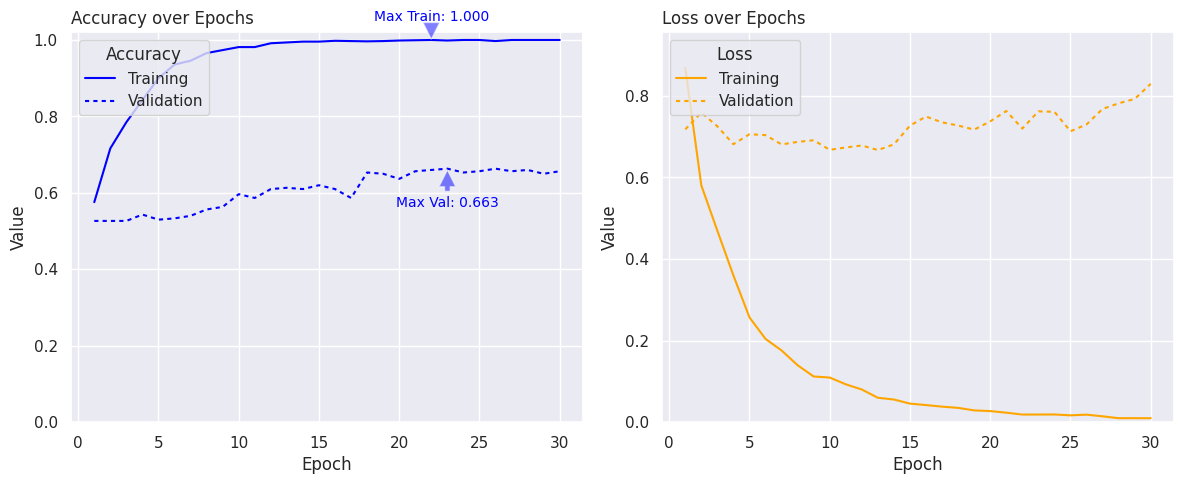

In [ ]:
cnn_c1_lr1, cnn_c1_lr1_history = train_cnn_model(train_data=[train_X, train_y], val_data=[val_X, val_y],
                                         cnn_model=cnn_c1_lr1, learning_rate = 0.0001)
plot_nn_epochs(nn_history=cnn_c1_lr1_history)

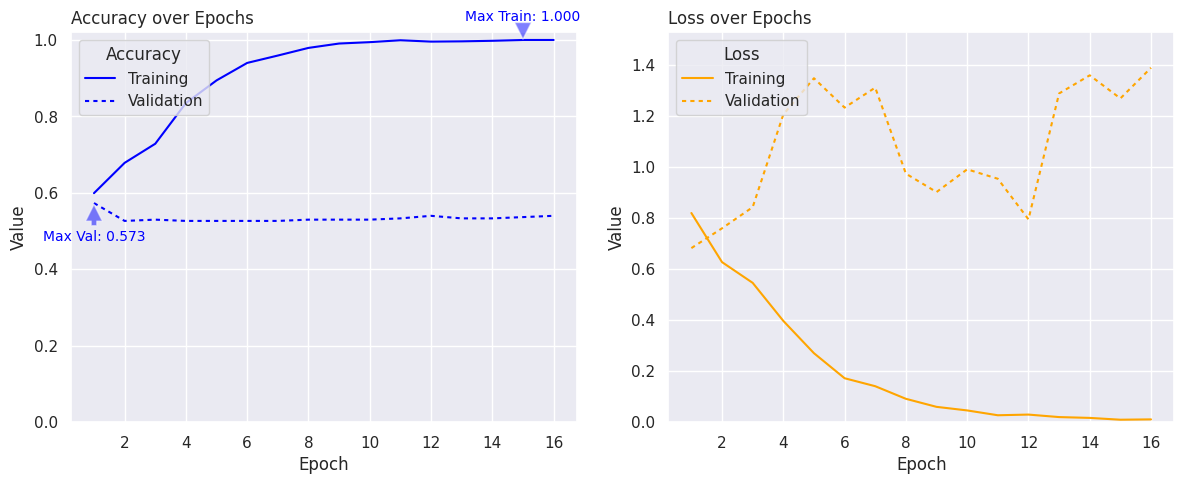

In [ ]:
cnn_c1_lr2, cnn_c1_lr2_history = train_cnn_model(train_data=[train_X, train_y], val_data=[val_X, val_y],
                                         cnn_model=cnn_c1_lr2, learning_rate = 0.001)
plot_nn_epochs(nn_history=cnn_c1_lr2_history)

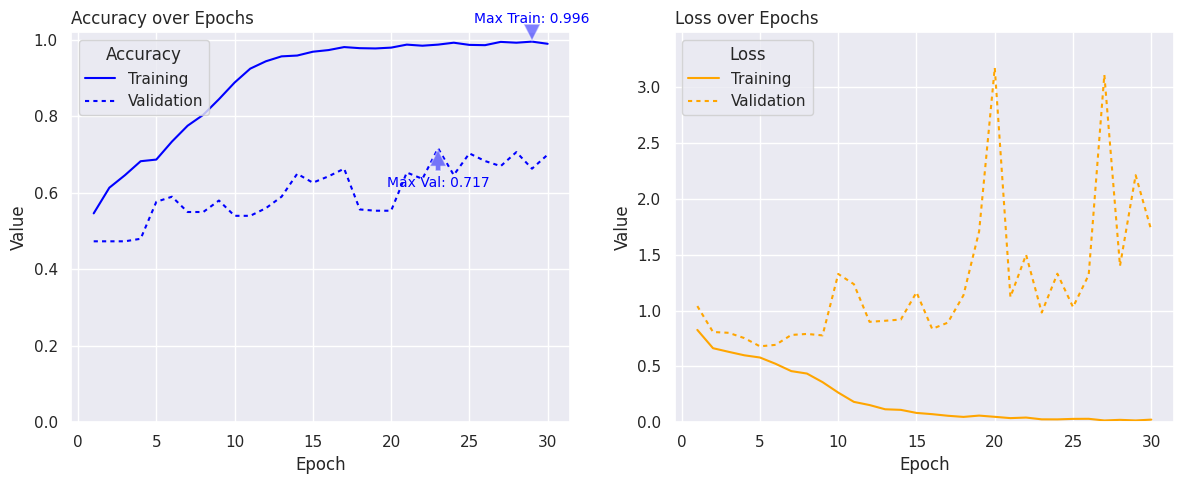

In [ ]:
cnn_c1_lr3, cnn_c1_lr3_history = train_cnn_model(train_data=[train_X, train_y], val_data=[val_X, val_y],
                                         cnn_model=cnn_c1_lr3, learning_rate = 0.01)
plot_nn_epochs(nn_history=cnn_c1_lr3_history)

In [ ]:
# Hyperparameter tuning: select the best CNN-C1 model
best_model_cnn1 = select_best_cnn_model(models = [cnn_c1_lr1, cnn_c1_lr2, cnn_c1_lr3], val_data = (val_X, val_y))

The best model is the one in the index position: 2


In two models, it can be seen that it takes some time for the CNNs to learn relevant features that really distinguish the classes, as approximately 10 epochs are required to surpass an accuracy of 0.6. Moreover, the increase of the difference in accuracy between training and validation throughout the epochs is an evidence of overfitting. The model with the intermediate learning rate does not seem to converge, as the accuracy in the validation set remains stale.

The best model is `cnn_c1_lr3`, corresponding to `learning_rate=0.01`. The results of this model in the test set further prove the existence of overfitting, as are quite distant from the ones in the training set. As final result, the simpler CNN model gets an accuracy of 0.650 and F1 of 0.649. This virtually improves or equals the results obtained by all the classic ML models, save the optimized Random Forest model.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


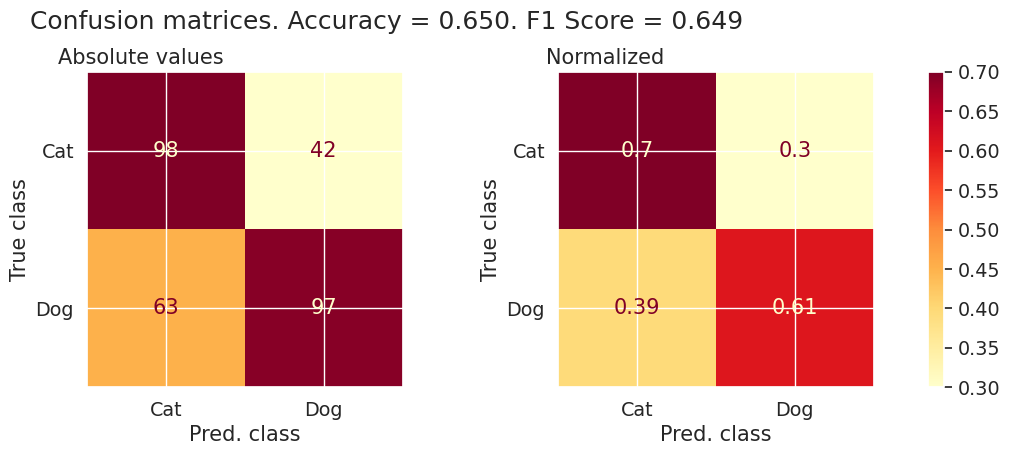

In [ ]:
cnn_c1_results = get_cnn_results(cnn_model=best_model_cnn1, data_X=test_X, true_class=test_y)
# Labelling of the results
cnn_c1_results["Model"] = "Conv. Neural Net."; cnn_c1_results["Features"] = "1 Conv. Block"

## Three convolutional blocks model (CNN-C3 model)
In order to capture more abstract features like the shape of an object, more convolutional blocks are needed. The CNN-C3 model has the following architecture: an input layer, three convolutional blocks and an output block. The amount of parameters is, approximately, the double than the model with a single convolutional block. The model is defined thrice to vary the learning rate in the training process.

In [ ]:
def create_cnn_c3_model():
  """
    Creates a CNN model with thre convolutional blocks for binary image classification. The model consists of
    an input layer accepting 150x150 RGB images, three convolutional block with [32, 64, 128] filters, ReLU
    activation, max pooling, and batch normalization (via `add_convolutional_blocks`), followed by a dense
    output block with 32 units, ReLU activation, dropout, and a sigmoid output layer (via `add_output_block`).

    Returns:
        keras.models.Sequential: A compiled CNN model ready for training.
  """
  cnn_c3 = Sequential()
  cnn_c3.add(InputLayer(shape=(150,150, 3)))
  cnn_c3 = add_convolutional_blocks(cnn_c3, conv_filters=[32, 64, 128], conv_kernel_size=(3,3),
                                      conv_activation='relu', conv_padding='same', pool_size=(2,2))
  cnn_c3 = add_output_block(cnn_c3, dense_units=256, dense_activation='relu', dropout_value=0.5)
  return cnn_c3

cnn_c3_lr1= create_cnn_c3_model(); cnn_c3_lr2= create_cnn_c3_model(); cnn_c3_lr3= create_cnn_c3_model()
cnn_c3_lr1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,907,169 (41.61 MB)

 Trainable params: 10,905,761 (41.60 MB)

 Non-trainable params: 1,408 (5.50 KB)

The following cells train one of the models using the training set and use the validation set to tune and optimize the parameters, preventing overfitting. In particular, the learning rate for the models are as follows: 0.0001 (`cnn_c3_lr1`; default value for the hyperparameter), 0.001 (`cnn_c3_lr2`), 0.01 (`cnn_c3_lr3`).

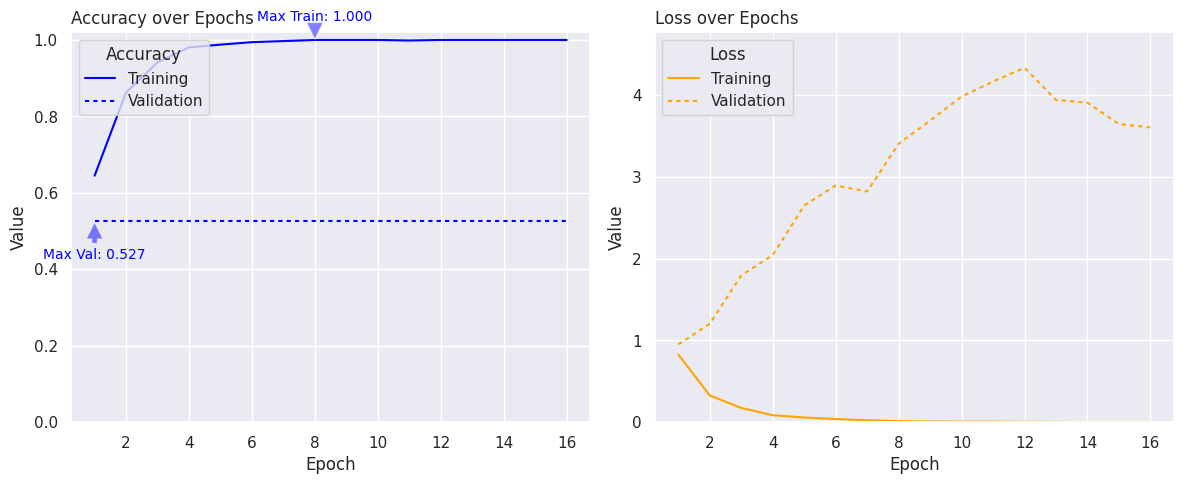

In [ ]:
cnn_c3_lr1, cnn_c3_lr1_history = train_cnn_model(train_data=[train_X, train_y], val_data=[val_X, val_y],
                                         cnn_model=cnn_c3_lr1, learning_rate = 0.0001)
plot_nn_epochs(nn_history=cnn_c3_lr1_history)

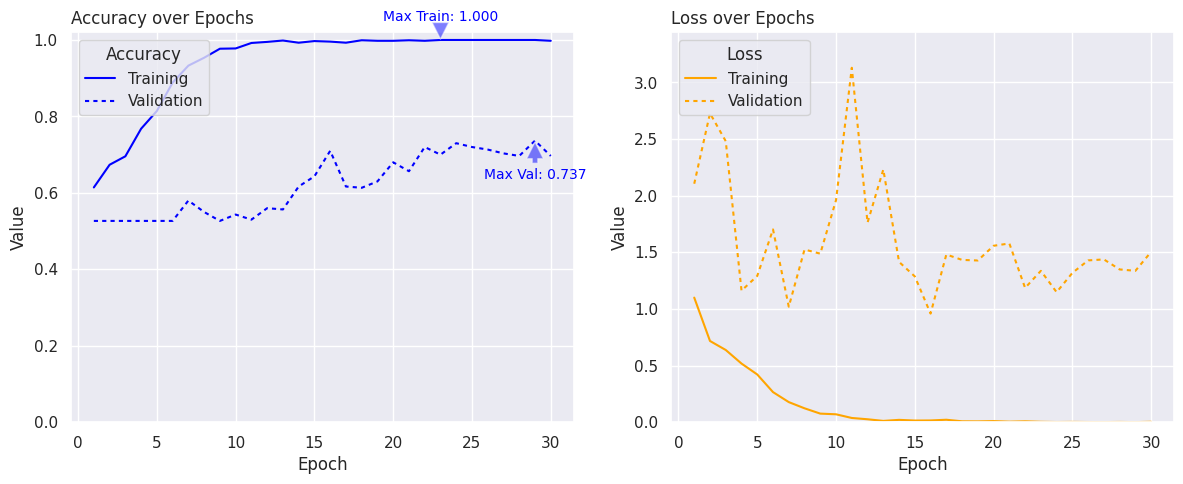

In [ ]:
cnn_c3_lr2, cnn_c3_lr2_history = train_cnn_model(train_data=[train_X, train_y], val_data=[val_X, val_y],
                                         cnn_model=cnn_c3_lr2, learning_rate = 0.001)
plot_nn_epochs(nn_history=cnn_c3_lr2_history)

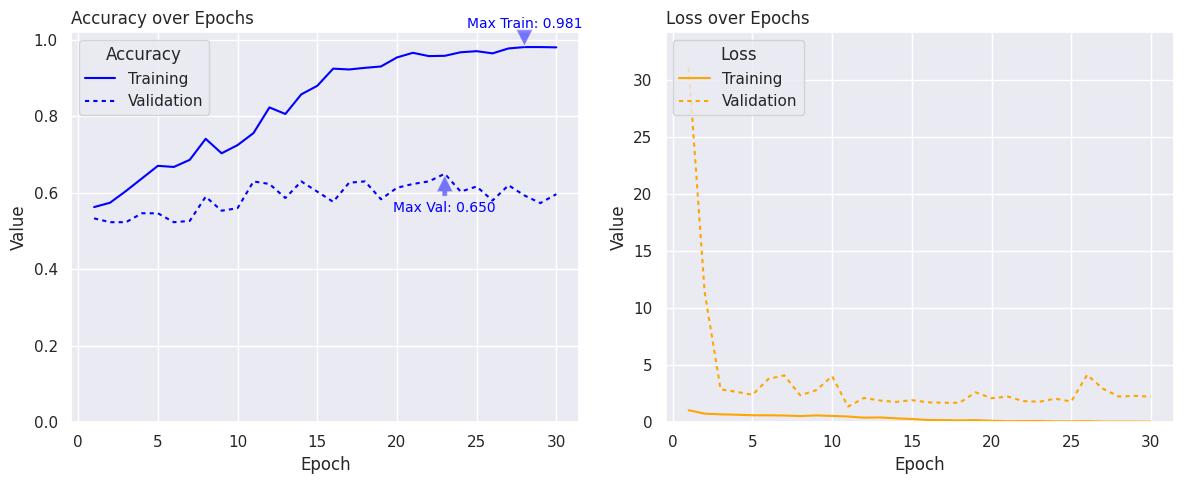

In [ ]:
cnn_c3_lr3, cnn_c3_lr3_history = train_cnn_model(train_data=[train_X, train_y], val_data=[val_X, val_y],
                                         cnn_model=cnn_c3_lr3, learning_rate = 0.01)
plot_nn_epochs(nn_history=cnn_c3_lr3_history)

In [ ]:
# Hyperparameter tuning: select the best CNN-C3 model
best_model_cnn3 = select_best_cnn_model(models = [cnn_c3_lr1, cnn_c3_lr2, cnn_c3_lr3], val_data = (val_X, val_y))

The best model is the one in the index position: 1


The model with the intermediate learning rate (`cnn_c3_lr2`; `learning_rate=0.001`) achieved the highest validation accuracy (0.7367) by balancing convergence speed and stability, while 0.0001 converged too slowly, and 0.01 caused unstable training. Even though severe dropout and batch normalization were used to regularize CNN-C3, overfitting persisted due to the small sample size of the dataset.

The next cell shows the performance of the model in the test set. The results of the model (accuracy: 0.713, F1 score: 0.719) are moderately better than the best model fitted until the moment, the Random Forest model with the HOG Features. Errors are balanced between classes.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


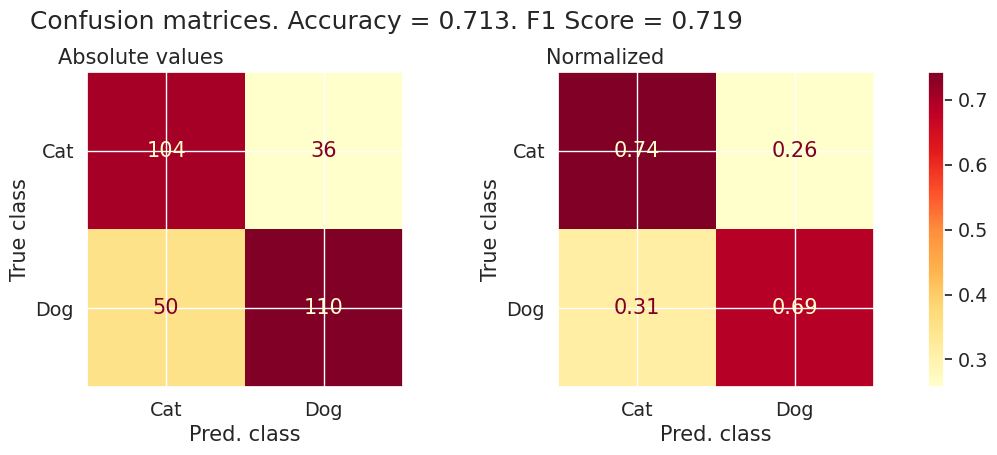

In [ ]:
cnn_c3_results = get_cnn_results(cnn_model=best_model_cnn3, data_X=test_X, true_class=test_y)
# Labelling of the results
cnn_c3_results["Model"] = "Conv. Neural Net."; cnn_c3_results["Features"] = "3 Conv. Block"

The examination of the misclassified images reveal the same pattern seen in the previous notebook. Errors are either noisy images (containing blurry sections, additional objects, or multiple animals) or seemingly normal images, in which the CNN is not able to effectively capture the animals' shapes and edges.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


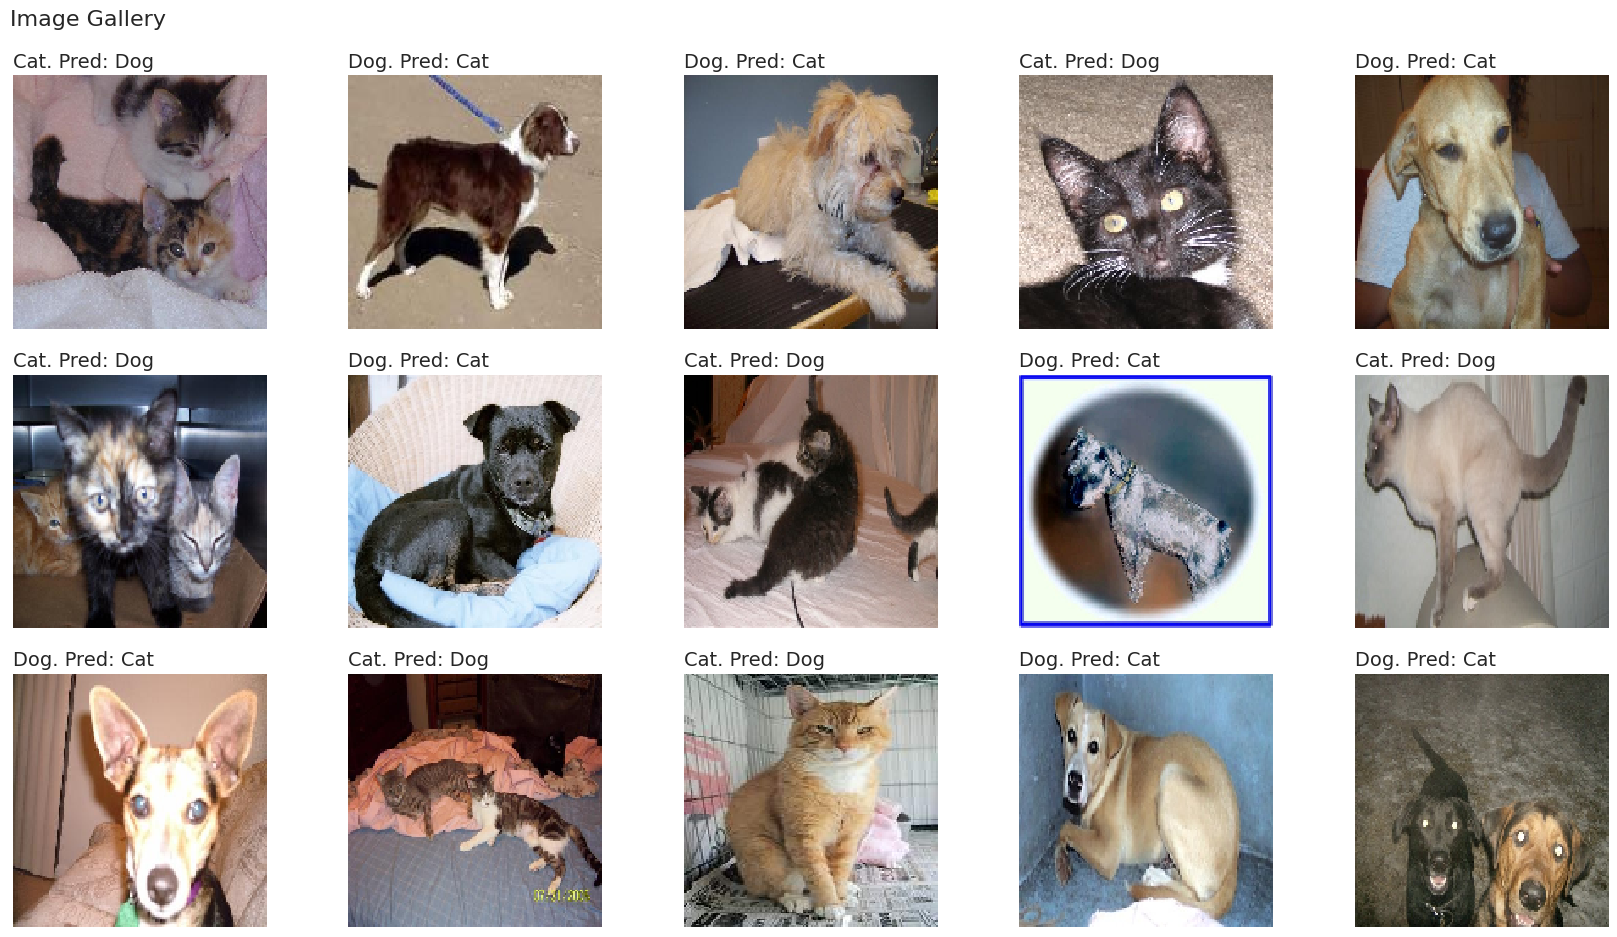

In [ ]:
# Predict the outcome. Get label instead of probability
pred_class_cnn_c3 = best_model_cnn3.predict(test_X).flatten()
pred_class_cnn_c3 = (pred_class_cnn_c3>0.5).astype(int)

# See some examples of wrong predictions
np.random.seed(1)
random_subset_wrong = np.random.choice((np.where(pred_class_cnn_c3!=test_y)[0]).tolist(), 15, replace=False)
plot_gallery(X_values = test_X, y_values = list(test_y),
             y_labels = pred_class_cnn_c3, selection = random_subset_wrong)

# Discussion and conclusion

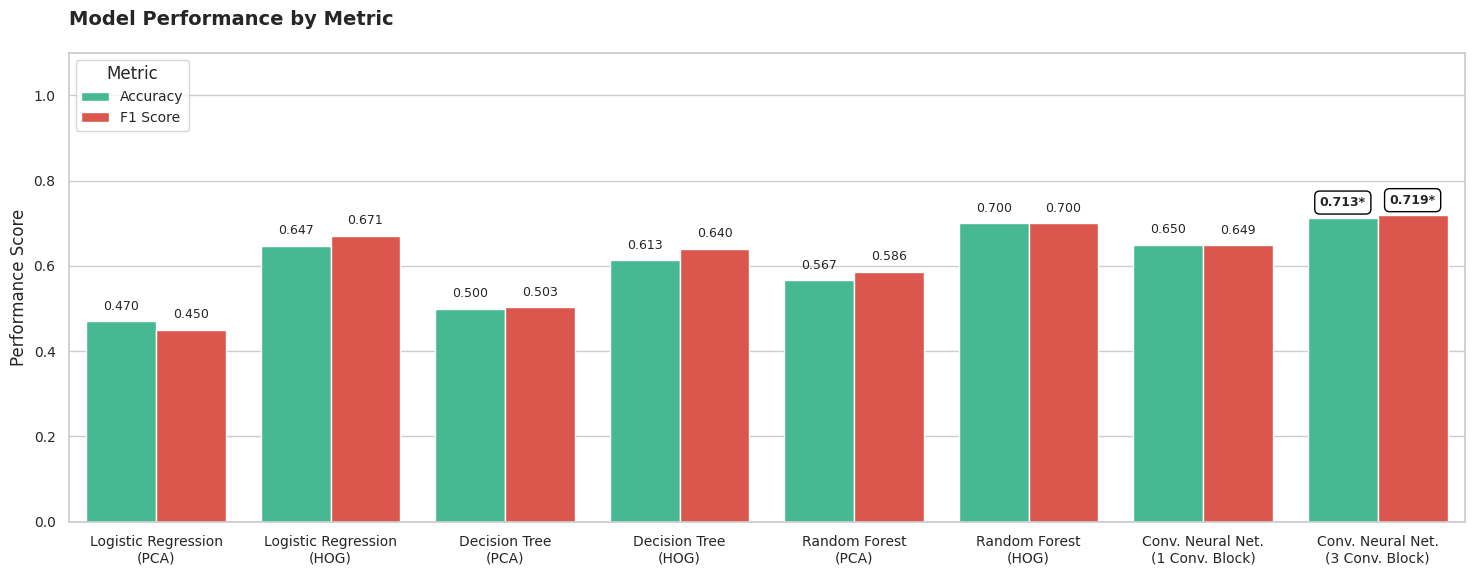

In [ ]:
# Load previous results, add the CNN results, and plot all of them
ml_results = load_previous_results()
cnn_results = pd.melt(pd.concat([cnn_c1_results, cnn_c3_results], ignore_index=True),
  id_vars=["Model", "Features"], var_name="Metric", value_vars=["Accuracy", "F1 Score"], value_name="Value")
plot_ml_results(pd.concat([ml_results, cnn_results]))

This study applied Convolutional Neural Networks (CNNs) to classify 2,000 preprocessed cat and dog images (150x150 pixels, 3 color channels) from the Cats-vs-Dogs dataset, comparing their performance to classic machine learning models (Logistic Regression, Decision Trees, Random Forest) used in the previous notebook. Two CNN architectures were developed: CNN-C1 (one convolutional block, 5.77M parameters) and CNN-C3 (three convolutional blocks, 10.91M parameters). The key findings and implications are summarized below.

## Key Findings

1. **Superiority of CNNs**: CNNs outperformed classic ML models by directly processing high-dimensional image data (67,500 features) without requiring dimensionality reduction (e.g., PCA, HOG). CNN-C1 achieved a test accuracy of 0.650 and an F1 score of 0.649, while CNN-C3 improved to 0.713 accuracy and 0.719 F1 score, surpassing the best classic ML model (Random Forest with HOG: 0.700 accuracy, 0.700 F1 score). This highlights CNNs’ ability to automatically extract hierarchical features (edges, textures, shapes) from raw pixels.
2. **Impact of Model Depth**: The deeper CNN-C3 model, with additional convolutional layers, captured more complex features, leading to a ~6% accuracy improvement over CNN-C1. However, the improvement was modest, suggesting diminishing returns with increased complexity given the dataset size.
3. **Overfitting Challenges**: Both models exhibited overfitting, with training accuracies nearing 1.0 while validation accuracies peaked at 0.7167 (CNN-C1) and 0.7367 (CNN-C3). The test set performance (0.650 and 0.713) confirmed limited generalization, likely due to the small dataset (2,000 images) relative to the models’ parameter counts. Analysis of misclassified images (e.g., blurry or multi-object images) suggests that CNNs struggled with noisy or ambiguous inputs.
4. **Balanced Performance**: Confusion matrices showed balanced errors between cats and dogs, indicating no significant class bias, which is critical for the balanced dataset.
5. **Hyperparameter Tuning**: Both models exhibited better performances using mid to high learning rates, as proven by the results in the validation set.


##Future Work and Applications

To address the limitations, particularly overfitting, the following strategies will be explored in the next notebook:
- **Transfer Learning**: Leveraging pre-trained models (e.g., VGG16, ResNet) fine-tuned on the Cats-vs-Dogs dataset could improve generalization by utilizing features learned from larger datasets like ImageNet. This is likely the most effective approach given the small dataset size.
- **Data Augmentation**: Techniques like random flips, rotations, and brightness adjustments could increase dataset diversity, though their impact may be limited for real-world generalization, as artificially generated data may not fully capture natural variability.
- **Hyperparameter Optimization**: Further tuning of hyperparameters, such as increasing the dropout or adjusting the number of convolutional filters, could reduce overfitting.
- **Larger Datasets**: Expanding the dataset with diverse images (e.g., varied backgrounds, poses) would support training deeper models and improve robustness.
- **Applications**: The CNN models show promise for automated pet identification in veterinary clinics, animal shelters, or mobile apps. The approach can be extended to other image classification tasks, such as wildlife monitoring or medical imaging, where distinguishing visual features is critical.

In conclusion, the CNNs demonstrated significant advantages over classic ML models for cat and dog image classification, effectively handling high-dimensional data without manual feature engineering. The deeper CNN-C3 model outperformed the simpler CNN-C1 and classic ML models, but overfitting remains a challenge due to the limited dataset size and model complexity. The next notebook will explore transfer learning to further enhance performance, paving the way for practical applications in image recognition.